In [1]:
import glob
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pandas as pd
import openmc
%matplotlib inline
import os 
os.environ['OPENMC_CROSS_SECTIONS']='/home/nushaer/Desktop/meh/endfb-viii.0-hdf5/cross_sections.xml'


In [2]:
uo2 = openmc.Material(name="uo2")
uo2.add_nuclide('U235', 0.15)
uo2.add_nuclide('U238', 0.85)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)

zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

stainless_steel = openmc.Material(name="stainless steel 316L")
stainless_steel.add_element('Fe',0.66)
stainless_steel.add_element('Cr', 0.17)
stainless_steel.add_element('Ni', 0.12)
stainless_steel.add_element('Mo',0.02)
stainless_steel.add_element('Mn',0.02)
stainless_steel.add_element('Si',0.01)
stainless_steel.set_density('g/cm3',8.0)

water = openmc.Material(name="h2o")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.add_nuclide('B10', 0.001)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

helium = openmc.Material(name="He")
helium.add_element('He', 1.0)
helium.set_density('g/cm3', 0.13)

graphite = openmc.Material(name='graphite')
graphite.add_element('C', 1.0)
zirconium.set_density('g/cm3', 2.26)

sodium = openmc.Material(name="sodium")
sodium.add_nuclide('Na23', 1.0)
sodium.set_density('g/cm3', 0.96)

puo2 = openmc.Material()
puo2.add_nuclide('Pu239', 0.94)
puo2.add_nuclide('Pu240', 0.06)
puo2.add_nuclide('O16', 2.0)
puo2.set_density('g/cm3', 11.5)

LBE = openmc.Material(name='Lead-Bismuth Eutectic')
LBE.add_element('Pb', 0.445)
LBE.add_element('Bi', 0.555)
LBE.set_density('g/cm3', 10.24)

reflector_mat = openmc.Material(name='Reflector')
reflector_mat.add_nuclide('Be9', 1.0)
reflector_mat.add_nuclide('O16', 1.0)
reflector_mat.set_density('g/cm3', 2.9)

mox = openmc.Material.mix_materials([uo2, puo2], [0.9, 0.1], 'wo')

materials = openmc.Materials([reflector_mat, uo2, zirconium, water, helium,puo2,mox,graphite,sodium,stainless_steel,LBE])

materials.export_to_xml()

In [3]:

all_water_out = openmc.Cell(cell_id=200, fill=water)
all_LBE_out = openmc.Cell(cell_id=201, fill=LBE)

assembly_z0 = openmc.ZPlane(surface_id=300, z0=-75)
assembly_z1 = openmc.ZPlane(surface_id=301, z0=75)
inner_assembly = openmc.model.hexagonal_prism(edge_length=5, orientation='y')
outer_assembly_in = openmc.model.hexagonal_prism(edge_length=7.688, orientation='y')
outer_assembly_out = openmc.model.hexagonal_prism(edge_length=10.1, orientation='y')
reflector = openmc.model.hexagonal_prism(edge_length=13, orientation='y',boundary_type='vacuum')

reflector_z0 = openmc.ZPlane(surface_id=303, z0=-95, boundary_type='vacuum')
reflector_z1 = openmc.ZPlane(surface_id=304, z0=95, boundary_type='vacuum')


inner_assembly_cell = openmc.Cell()
outer_assembly_cell = openmc.Cell()
reflector_cell = openmc.Cell()
top_reflect_cell = openmc.Cell()
bot_reflect_cell = openmc.Cell()
border_cell = openmc.Cell()


previously:

all_water_out = openmc.Cell(cell_id=200, fill=water)
all_LBE_out = openmc.Cell(cell_id=201, fill=LBE)

assembly_z0 = openmc.ZPlane(surface_id=300, z0=-75)
assembly_z1 = openmc.ZPlane(surface_id=301, z0=75)
assembly = openmc.model.hexagonal_prism(edge_length=7, orientation='y')
outer_assembly = openmc.model.hexagonal_prism(edge_length=13, orientation='y')

reflector_z0 = openmc.ZPlane(surface_id=303, z0=-95, boundary_type='vacuum')
reflector_z1 = openmc.ZPlane(surface_id=304, z0=95, boundary_type='vacuum')

reflector = openmc.model.hexagonal_prism(edge_length=8, orientation='y',boundary_type='vacuum')
outer_reflector = openmc.model.hexagonal_prism(edge_length=14, orientation='y',boundary_type='reflective')
ss_inborder = openmc.model.hexagonal_prism(edge_length=8, orientation='y', boundary_type='vacuum')
ss_outborder = openmc.model.hexagonal_prism(edge_length=9, orientation='y', boundary_type='vacuum')


assembly_cell = openmc.Cell()
outer_assembly_cell = openmc.Cell()
reflect_cell = openmc.Cell()
outer_reflect_cell = openmc.Cell()
top_reflect_cell = openmc.Cell()
bot_reflect_cell = openmc.Cell()
border_cell = openmc.Cell()

In [4]:
inner_assembly_cell.region = inner_assembly & -assembly_z1 & +assembly_z0

border_cell.region = ~inner_assembly & outer_assembly_in & -assembly_z1 & +assembly_z0

outer_assembly_cell.region = ~outer_assembly_in & outer_assembly_out & -assembly_z1 & +assembly_z0

reflector_cell.region = ~outer_assembly_out & reflector & -assembly_z1 & +assembly_z0

top_reflect_cell.region = reflector & +assembly_z1 & -reflector_z1 

bot_reflect_cell.region = reflector & -assembly_z0 & +reflector_z0


reflector_cell.fill = graphite
top_reflect_cell.fill = graphite
bot_reflect_cell.fill = graphite
border_cell.fill = stainless_steel

all_water_out_u = openmc.Universe(cells=[all_water_out])
all_LBE_out_u = openmc.Universe(cells=[all_LBE_out])

u_reflect = openmc.Universe(cells=(reflector_cell,top_reflect_cell,bot_reflect_cell))
u_root = openmc.Universe()


assembly_cell.region = assembly & -assembly_z1 & +assembly_z0

outer_assembly_cell.region = ~reflector & outer_assembly & -assembly_z1 & +assembly_z0

reflect_cell.region = ~assembly & reflector & -assembly_z1 & +assembly_z0

outer_reflect_cell.region = ~outer_assembly & outer_reflector & -assembly_z1 & +assembly_z0

top_reflect_cell.region = reflector & +assembly_z1 & -reflector_z1 

bot_reflect_cell.region = reflector & -assembly_z0 & +reflector_z0

border_cell.region = ~ss_inborder & ss_outborder & -assembly_z1 & +assembly_z0

reflect_cell.fill = stainless_steel
outer_reflect_cell.fill = graphite
top_reflect_cell.fill = graphite
bot_reflect_cell.fill = graphite
border_cell.fill = stainless_steel

all_water_out_u = openmc.Universe(cells=[all_water_out])
all_LBE_out_u = openmc.Universe(cells=[all_LBE_out])

u_reflect = openmc.Universe(cells=(reflect_cell,top_reflect_cell,bot_reflect_cell))
u_root = openmc.Universe()

In [5]:
fuel_ir1 = openmc.ZCylinder(r=0.20)
fuel_or1 = openmc.ZCylinder(r=0.39)
clad_ir1 = openmc.ZCylinder(r=0.40)
clad_or1 = openmc.ZCylinder(r=0.46)

fuel_region1 = +fuel_ir1 & -fuel_or1 & -assembly_z1 & +assembly_z0
gap_region1  = +fuel_or1 & -clad_ir1 & -assembly_z1 & +assembly_z0
clad_region1 = +fuel_or1 & -clad_or1 & -assembly_z1 & +assembly_z0
center_region1 = -fuel_ir1

moderator_region1 = +clad_or1 & -assembly_z1 & +assembly_z0

fuel_cell1 = openmc.Cell(cell_id=400, fill=mox, region=fuel_region1)
clad_cell1 = openmc.Cell(cell_id=401, fill=stainless_steel, region=clad_region1)
mod_cell1 = openmc.Cell(cell_id=402, fill=LBE, region=moderator_region1)
center_cell1 = openmc.Cell(cell_id=403, fill=helium, region=center_region1)
gap_cell1   = openmc.Cell(cell_id=404, fill=helium, region=gap_region1)

fast_fuel = openmc.Universe(cells=[fuel_cell1, clad_cell1, mod_cell1,gap_cell1,center_cell1])


In [6]:
fuel_ir2 = openmc.ZCylinder(r=0.20)
fuel_or2 = openmc.ZCylinder(r=0.39)
clad_ir2 = openmc.ZCylinder(r=0.40)
clad_or2 = openmc.ZCylinder(r=0.46)

fuel_region2 = +fuel_ir2 & -fuel_or2 & -assembly_z1 & +assembly_z0
gap_region2  = +fuel_or2 & -clad_ir2 & -assembly_z1 & +assembly_z0
clad_region2 = +fuel_or2 & -clad_or2 & -assembly_z1 & +assembly_z0
center_region2 = -fuel_ir2

moderator_region2 = +clad_or2 & -assembly_z1 & +assembly_z0

fuel_cell2 = openmc.Cell(cell_id=500, fill=uo2, region=fuel_region2)
clad_cell2 = openmc.Cell(cell_id=501, fill=stainless_steel, region=clad_region2)
mod_cell2 = openmc.Cell(cell_id=502, fill=water, region=moderator_region2)
center_cell2 = openmc.Cell(cell_id=503, fill=helium, region=center_region2)
gap_cell2   = openmc.Cell(cell_id=504, fill=helium, region=gap_region2)

thermal_fuel = openmc.Universe(cells=[fuel_cell2, clad_cell2, mod_cell2,gap_cell2,center_cell2])

In [7]:
fuel_ir3 = openmc.ZCylinder(r=0.20)
fuel_or3 = openmc.ZCylinder(r=0.39)
clad_ir3 = openmc.ZCylinder(r=0.40)
clad_or3 = openmc.ZCylinder(r=0.46)

fuel_region3 = +fuel_ir3 & -fuel_or3 & -assembly_z1 & +assembly_z0
gap_region3  = +fuel_or3 & -clad_ir3 & -assembly_z1 & +assembly_z0
clad_region3 = +fuel_or3 & -clad_or3 & -assembly_z1 & +assembly_z0
center_region3 = -fuel_ir3

moderator_region3 = +clad_or3 & -assembly_z1 & +assembly_z0

fuel_cell3 = openmc.Cell(cell_id=600 , fill=LBE, region=fuel_region3)
clad_cell3 = openmc.Cell(cell_id=601, fill=LBE, region=clad_region3)
mod_cell3 = openmc.Cell(cell_id=602, fill=LBE, region=moderator_region3)
center_cell3 = openmc.Cell(cell_id=603, fill=LBE, region=center_region3)
gap_cell3   = openmc.Cell(cell_id=604, fill=LBE, region=gap_region3)

blank_fuel = openmc.Universe(cells=[fuel_cell3, clad_cell3, mod_cell3,gap_cell3,center_cell3])

In [8]:
fuel_ir4 = openmc.ZCylinder(r=0.20)
fuel_or4 = openmc.ZCylinder(r=0.39)
clad_ir4 = openmc.ZCylinder(r=0.40)
clad_or4 = openmc.ZCylinder(r=0.46)

fuel_region4 = +fuel_ir4 & -fuel_or4 & -assembly_z1 & +assembly_z0
gap_region4  = +fuel_or4 & -clad_ir4 & -assembly_z1 & +assembly_z0
clad_region4 = +fuel_or4 & -clad_or4 & -assembly_z1 & +assembly_z0
center_region4 = -fuel_ir4

moderator_region4 = +clad_or4 & -assembly_z1 & +assembly_z0

fuel_cell4 = openmc.Cell(cell_id=700 , fill=stainless_steel, region=fuel_region4)
clad_cell4 = openmc.Cell(cell_id=701, fill=stainless_steel, region=clad_region4)
mod_cell4 = openmc.Cell(cell_id=702, fill=stainless_steel, region=moderator_region4)
center_cell4 = openmc.Cell(cell_id=703, fill=stainless_steel, region=center_region4)
gap_cell4   = openmc.Cell(cell_id=704, fill=stainless_steel, region=gap_region4)

blank_fuel1 = openmc.Universe(cells=[fuel_cell4, clad_cell4, mod_cell4,gap_cell4,center_cell4])

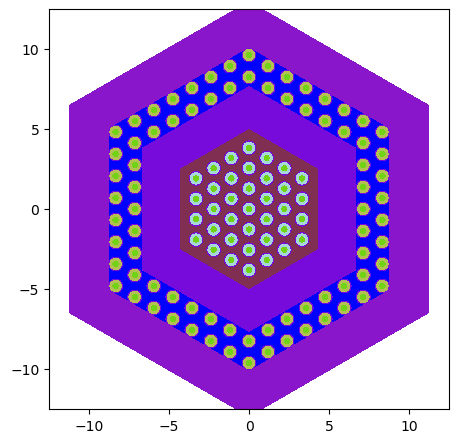

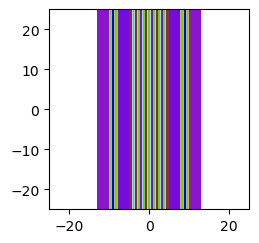

In [9]:
lat=openmc.HexLattice(name='fast assembly')
lat.center = (0., 0.)
lat.pitch = (1.275,)
lat.outer=all_LBE_out_u 

ring9=[thermal_fuel]*54
ring8=[thermal_fuel]*48
ring7=[thermal_fuel]*42
ring6=[thermal_fuel]*36
ring5=[thermal_fuel]*30
ring4=[fast_fuel]*24
ring3=[fast_fuel]*18
ring2=[fast_fuel]*12
ring1=[fast_fuel]*6
ring0=[fast_fuel]
lat.universes = [ring3, ring2, ring1 , ring0]
lat.orientation='y'

lat1=openmc.HexLattice(name='thermal assembly')
lat1.center = (0., 0.)
lat1.pitch = (1.375,)
lat1.outer=all_water_out_u 
lat1.universes = [ring9,ring8,ring7,ring6,ring5,ring4,ring3, ring2, ring1 , ring0]
lat1.orientation='y'

inner_assembly_cell.fill = lat
outer_assembly_cell.fill = lat1

u_root.add_cells([border_cell, inner_assembly_cell, reflector_cell, top_reflect_cell, bot_reflect_cell,outer_assembly_cell])
geom=openmc.Geometry(u_root)
geom.export_to_xml()

u_root.plot(origin=(0,0,0),width=(25,25),color_by='material',colors={water:'blue'},pixels=[400,400])

u_root.plot(basis='yz',origin=(0,0,0),width=(50,50),color_by='material',colors={water:'blue'},pixels=[200,200])

lat=openmc.HexLattice(name='fast assembly')
lat.center = (0., 0.)
lat.pitch = (1.275,)
lat.outer=all_LBE_out_u 

ring9=[thermal_fuel]*54
ring8=[thermal_fuel]*48
ring7=[thermal_fuel]*42
ring6=[blank_fuel1]*36
ring5=[fast_fuel]*30
ring4=[fast_fuel]*24
ring3=[fast_fuel]*18
ring2=[fast_fuel]*12
ring1=[fast_fuel]*6
ring0=[fast_fuel]
lat.universes = [ring9,ring8, ring7, ring6, ring5, ring4, ring3, ring2, ring1 , ring0]
lat.orientation='y'

lat1=openmc.HexLattice(name='thermal assembly')
lat1.center = (0., 0.)
lat1.pitch = (1.275,)
lat1.outer=all_water_out_u 
lat1.universes = [ring9, ring8, ring7, ring6, ring5, ring4, ring3, ring2, ring1 , ring0]
lat1.orientation='y'


assembly_cell.fill = lat
outer_assembly_cell.fill = lat1

u_root.add_cells([border_cell,assembly_cell, outer_reflect_cell, reflect_cell, top_reflect_cell, bot_reflect_cell,outer_assembly_cell])
geom=openmc.Geometry(u_root)
geom.export_to_xml()

u_root.plot(origin=(0,0,0),width=(25,25),color_by='material',colors={water:'blue'},pixels=[400,400])

u_root.plot(basis='yz',origin=(0,0,0),width=(50,50),color_by='material',colors={water:'blue'},pixels=[200,200])

In [10]:
batches = 200
inactive = 50
particles = 5000

settings = openmc.Settings()
settings.batches = batches
settings.inactive = inactive
settings.particles = particles


settings.export_to_xml()

In [11]:
tallies = openmc.Tallies()

mesh = openmc.RegularMesh()
mesh.dimension = [1000,1000]
mesh.lower_left = [-20, -20]
mesh.upper_right = [20, 20]

mesh_filter = openmc.MeshFilter(mesh)


tally = openmc.Tally(name='flux')
tally.filters = [mesh_filter]
tally.scores = ['flux','fission']
tallies.append(tally)

tallies.export_to_xml()

In [12]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

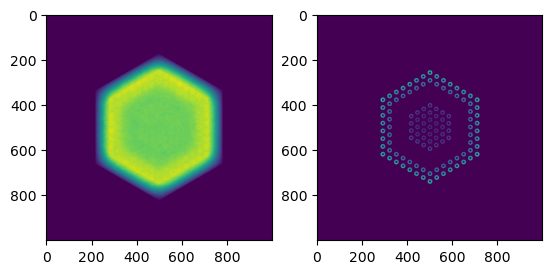

In [13]:
sp = openmc.StatePoint('statepoint.200.h5')

tally = sp.get_tally(scores=['flux'])

flux = tally.get_slice(scores=['flux'])
fission = tally.get_slice(scores=['fission'])

flux.std_dev.shape = (1000,1000)
flux.mean.shape = (1000,1000)
fission.std_dev.shape = (1000,1000)
fission.mean.shape = (1000,1000)

fig = plt.subplot(121)
fig.imshow(flux.mean)
fig2 = plt.subplot(122)
fig2.imshow(fission.mean)